In [948]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import os
from math import *

In [949]:
#Parameters
mu = [np.zeros(3),np.array([1,5,-3]),np.zeros(3)]
sig = [np.diag([3,5,2]),np.array([[1,0,0],
                                  [0,4,1],
                                  [0,1,6]]),10*np.eye(3)]

In [950]:
data_set = [np.random.multivariate_normal(mu[i],sig[i],20) for i in range(3)]

In [951]:
#ML estimate functions
def mean_est_fun(data):
    n,m=data.shape
    mu=sum(data)/n
    return mu
def cov_est_fun(data):
    n,m=data.shape
    x=data-mean_est_fun(data)
    cov_mat=(x.transpose() @ x)/n
    return cov_mat

In [952]:
#Part a) Estimation of mean and covariance matrix
mean_est = []
cov_est = []
for i in range(3):
    mean_est.append(mean_est_fun(data_set[i]))
    cov_est.append(cov_est_fun(data_set[i]))
for i in range(3):
    print(r'mu '+str(i)+'= ',mean_est[i])
for i in range(3):
    print(r'Sigma '+str(i)+'= ',cov_est[i],sep='\n')

mu 0=  [ 0.39045171  0.57211118 -0.04090402]
mu 1=  [ 0.83675365  5.87149345 -3.80256701]
mu 2=  [1.23585846 0.19504445 1.06485597]
Sigma 0= 
[[ 2.03634639 -0.43923157  0.31778526]
 [-0.43923157  3.63076433 -1.09952291]
 [ 0.31778526 -1.09952291  2.58115812]]
Sigma 1= 
[[0.84353473 0.08810267 0.22540822]
 [0.08810267 3.86669101 0.33508424]
 [0.22540822 0.33508424 4.19609371]]
Sigma 2= 
[[ 8.17806349 -0.47131682 -2.91053948]
 [-0.47131682 11.07629371  3.74818511]
 [-2.91053948  3.74818511  9.58587769]]


In [953]:
#Data need to be normalised before finding total covariance
def normalize_man(data):
    data_diff = data-np.mean(data,0)
    return data_diff/np.std(data,0)

In [954]:
#Calculation of total_cov
data_n = [normalize_man(data_set[i]) for i in range(3)]
data_con = np.concatenate((data_n[0],data_n[1],data_n[2]),axis=0)
(cov_total,mu_total) = (cov_ml_est(data_con),mean_ml_est(data_con))
print(r'Sigma Total= ',cov_total,sep='\n')

Sigma Total= 
[[ 1.         -0.05409132 -0.02343401]
 [-0.05409132  1.          0.029258  ]
 [-0.02343401  0.029258    1.        ]]


In [955]:
#Shrinking function
def cov_shrink(cov_i,cov_n,a): #0<a<1
    n_i,n = 20,60
    cov_s=(((1-a)*n_i*cov_i) + (a*n*cov_n))/((1-a)*n_i + a*n)
    return cov_s

In [956]:
#Train labels generation
train=pd.DataFrame(data_con,columns=['x1','x2','x3'])
train_labels=[i for i in range(3) for j in range(20)]
train_labels=pd.DataFrame(train_labels,columns=['train_class'])

In [957]:
#Note prior = 1/3 as all the classes are equiprobable
#Bayes Class posterior and risk functions
class B_Class:
    def __init__(self,p=1/3,mu_class=np.zeros((3,1)),cov_class = np.zeros((3,3))):

        self.prob = p
        self.mean = mu_class
        self.cov_matrix = cov_class

    def posterior(self,X):
        p = self.prob
        mu_class = self.mean
        cov_class = self.cov_matrix
        cov_inv = np.linalg.inv(cov_class)
        cov_det = abs(np.linalg.det(cov_class))
        n = X.size
        X_dif=X-mu_class
        Z= X_dif.T @ cov_inv @ X_dif
        return p/np.sqrt(((2*pi)**n)*cov_det)*exp(-Z/2)

def Risk(X,L,n,c):
    u = np.array([c[0].posterior(X),c[1].posterior(X),c[2].posterior(X)])
    v = L[n,:]
    return np.dot(u,v)

In [958]:
#Instances of class are initiated with means as ml estimated means
class_b=[B_Class() for i in range(3)]
for i in range(3):
    class_b[i].mean=mean_est[i]

In [959]:
#Bayes classifier for classes with different covariances
def classifier(data,cov_1,cov_2,cov_3,class_b): 
    L = np.array([[0,1,1],[1,0,1],[1,1,0]])
    class_b[0].cov_matrix = cov_1
    class_b[1].cov_matrix = cov_2
    class_b[2].cov_matrix = cov_3
    labels_est = np.array([])
    for i, r in data.iterrows():
        X = r.values
        risks = [ Risk(X,L,0,class_b), Risk(X,L,1,class_b), Risk(X,L,2,class_b) ]
        i_min=risks.index(min(risks))
        labels_est=np.append(labels_est,i_min) #Conversion needed as append gives error for class<'int'>
        labels_est=pd.DataFrame(labels_est)
    return labels_est

In [960]:
#Bayes classifier trained
a = np.linspace(0,1,100)
errors_train = []

for alpha in a:

    cov_s = [cov_shrink(cov_est[i],cov_total,alpha) for i in range(3) ]
    out_labels = classifier(train,cov_s[0],cov_s[1],cov_s[2],class_b)
    errors_train.append(mean_squared_error(train_labels,out_labels))

Text(0.5, 1.0, 'Training Error vs $\\alpha$ for 20 data sets for each equiprobable class')

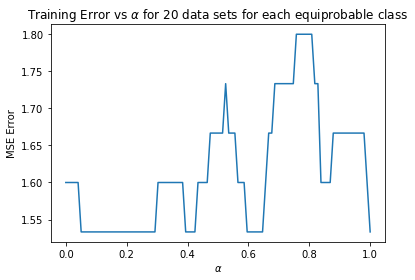

In [961]:
#Training error plot vs alpha
plt.figure()
plt.plot(alphas,errors)
plt.xlabel(r'$\alpha$')
plt.ylabel('MSE Error')
plt.title(r'Training Error vs $\alpha$ for 20 data sets for each equiprobable class')

In [962]:
#Test data generation

test_l = [np.random.multivariate_normal(mu[i],sig[i],size =50) for i in range(3)]

test = pd.DataFrame(np.concatenate((test_l[0],test_l[1],test_l[2]),axis=0),columns=['x1','x2','x3'])
test_labels=[i for i in range(3) for j in range(50)]
test_labels=pd.DataFrame(test_labels,columns=['test_class'])

In [963]:
# Bayes classifier tested

a = np.linspace(0,1,100)
errors_test  = []

for alpha in a:

    cov_s = [cov_shrink(cov_est[i],cov_total,alpha) for i in range(3) ]
    out_labels = classifier(test,cov_s[0],cov_s[1],cov_s[2],class_b)
    errors_test.append(mean_squared_error(test_labels,out_labels))

Text(0.5, 1.0, 'Test Error vs $\\alpha$ for 50 data sets for each equiprobable class')

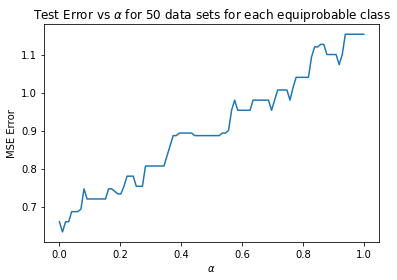

In [964]:
#Plot of Test error vs alpha
plt.figure()
plt.plot(alphas_test,errors_test)
plt.xlabel(r'$\alpha$')
plt.ylabel('MSE Error')
plt.title(r'Test Error vs $\alpha$ for 50 data sets for each equiprobable class')